# DeepGenome

Here, we introduce a framework for training a machine learning algorithm to learn the basic genetic principles underlying the gene composition of bacterial genomes. Given a set of desired pathways (e.g., glycolysis, TCA cycle, and butane degradation), our variational autoencoder (VAE) model strives to generate synthetic bacterial "genome vectors" - vectors denoting the full complement of genes that would need to be encoded to support a viable cell that supports the user-defined input functions.

This ipython notebook allows a user to:
- Load, pre-process, and filter data
- Perform data exploration on dataset & train-test splits
- Train or load a single VAE model
- Evaluate the output of the model
- Generate figures for the manuscript

To perform hyperparameter optimization, please use the hpo.py module. 

A few things to note about the data:
- Each genome has both a tla and tnum that can be used to identify it (tla = three letter abbreviation = genome ID, tnum = T number = genome ID)
- The terms "KO" (KEGG orthology number) and "gene" are used interchangeably

### Load libraries, format settings

In [1]:
# automatically upload modules
%load_ext autoreload
%autoreload 2

In [3]:
from collections import defaultdict
import random
import re
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import ray
from ray import tune
from scipy import stats
import sklearn as sk
import torch

from genome_embeddings import corrupt, data, data_viz, evaluate, models, pathways, pre_process, trainable 

In [4]:
BASE_DIR = '/Users/natasha/Desktop/vae/'
DATA_DIR = '/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/kegg_dataset/'
replacement_threshold = 0.5 # probability over which binarizer converts to a 1  
plt.rcParams.update({'font.size': 14})

# Load dataset

In [258]:
tla_to_mod_to_kos, mod_sets, tla_to_tnum, \
tnum_to_tla, keepers, tnum_to_kos, n_kos_tot, all_kos, \
mod_to_ko_clean, all_kos,  \
train_data, test_data, train_genomes, test_genomes = pre_process.load_data(BASE_DIR, DATA_DIR)

# Data exploration

Start by exploring properties of the dataset. This will help determine how we want to apply filters, etc.

A single KEGG module can often be represented by multiple sets of genes (pre-filtering). Given that we are working with a dataset of limited size, we have represented each module by a single set of genes. That set is the most common one found in the full dataset. The histogram function below allows one to visualize the original diversity of gene sets per module. For example, for module M00001 (EMP glycolysis, glucose => pyruvate) there are 401 different variants of the module, each with a slightly different combination of genes. 

The most common variant of module M00001 occurs in 73 genomes. There are a total of 401 module variants.


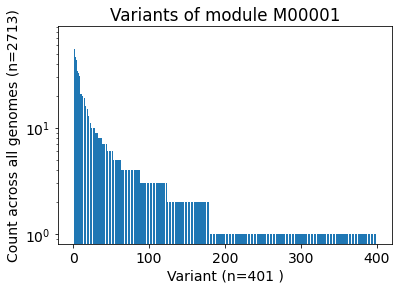

In [6]:
mod = 'M00001'
fig = data_viz.variants_of_mod(mod, mod_sets, tla_to_mod_to_kos)

Plot histogram of KOs per genome in the full dataset (pre-filtering).

Median: 1835.0 Min: 0 Max: 4536


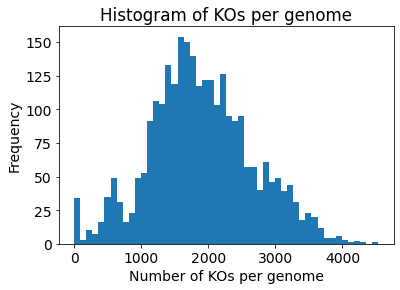

In [7]:
fig = data_viz.kos_per_genome(BASE_DIR, tnum_to_kos, train_genomes, test_genomes)

Plot the number of modules encoded by each genome

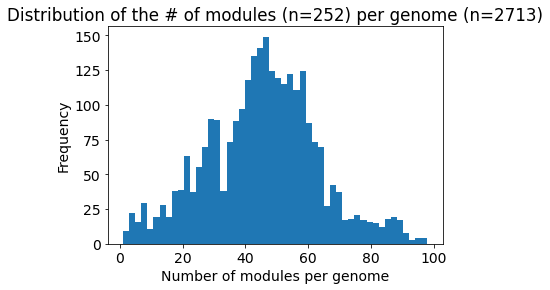

In [8]:
fig = data_viz.mods_by_genomes(tla_to_mod_to_kos)

Count and plot the number of genomes that encode each module (pre-filtering)

Number of mods encoded in only one genome: 23
Max number of genomes encoding a single mod 2672


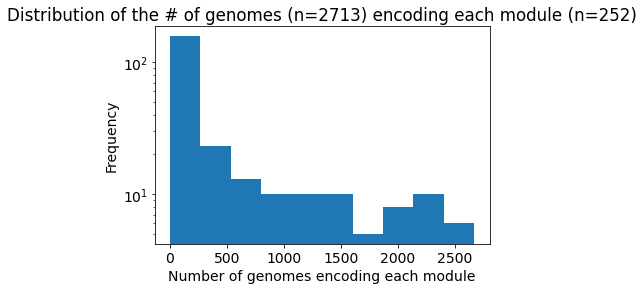

In [9]:
fig = data_viz.distrib_num_genomes_with_mod(tla_to_mod_to_kos)

Plot the percentage of genes per genome that contribute to modules, calculate some relevant stats

The total number of genes that occur in mods is 1359
The total number of genes in the dataset is 9874
Across the full dataset, the % of KOs that contribute to mods is 13.76%


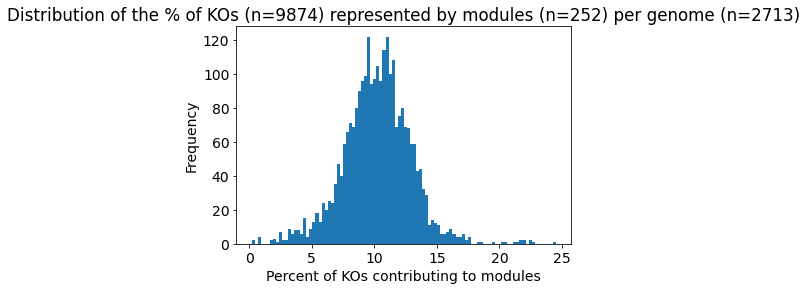

In [10]:
fig = data_viz.perc_genes_in_mods(tla_to_mod_to_kos, tnum_to_kos, tla_to_tnum, all_kos)

# Filter dataset

Remove any genomes with fewer than n_min KOs (e.g., this may represent endosymbionts or other bacteria with unusual lifestyles)

In [322]:
n_min = 500
train_data, test_data, train_genomes, test_genomes = pre_process.filter(n_min, train_data, test_data, 
                                                                        train_genomes, test_genomes)

Remove genomes that encode fewer than n_mods modules (anomalous)

In [323]:
n_mods = 10
train_data, train_genomes = pre_process.remove_low_nmods(train_data, train_genomes, \
                                                         tnum_to_tla, tla_to_mod_to_kos, n_mods)
test_data, test_genomes = pre_process.remove_low_nmods(test_data, test_genomes, \
                                                       tnum_to_tla, tla_to_mod_to_kos, n_mods)

Remove any columns that are all zeros in both the train and test sets (adjust train_data, test_data, and all_kos)

In [324]:
good_cols = ((train_data.sum(axis=0) != 0) | (test_data.sum(axis=0) != 0))
train_data = train_data[:,good_cols]
test_data = test_data[:,good_cols]
all_kos = np.array(all_kos)[good_cols].tolist()

Check how many rows and columns have all zeros for the training and test sets, respectively (# rows with all zeros, # columns with all zeros). 

Note that the number of all-zero rows should be zero for both. The number of all-zero columns will not be zero because in some cases, a gene may only one genome -- or a small number of genomes -- and occurs only in the training or test set.

In [325]:
# In just the training set, how many genomes and genes have zero entries 
(train_data.sum(axis=1) == 0).sum(), (train_data.sum(axis=0) == 0).sum()

(0, 77)

In [326]:
# In just the test set, how many genomes and genes have zero entries
(test_data.sum(axis=1) == 0).sum(), (test_data.sum(axis=0) == 0).sum()

(0, 1595)

Print some helpful stats

In [327]:
pre_process.helpful_data_stats(train_data, test_data)

The training set consists of 2305 genomes
The test set consists of 279 genomes
In total there are 2584 genomes
In total there are 9863 genes


# Corrupt input genomes
Due to the limited dataset size, we are going to perform corruptions on each genome and use those corrupted versions as input the the VAE. The model will be evaluated on how well it reconstructs the original, uncorrupted genome vector.

Note: creating new corruptions may take a while

In [17]:
# Set parameters
new_corrupt = False # do we want to create new corruptions or load from file
n_corrupt = 100
n_mods = 10 # max number of mods to keep during corruption
date_to_save = "2021-01-05_"+str(n_mods)+"mods" # if new_corrupt = True, will save corruptions as this
date_to_load = "2021-01-05_10mods" # if new_corrupt = False will load these

if new_corrupt:
    corrupted_train, c_train_genomes, train_input_mods, \
    corrupted_test, c_test_genomes, test_input_mods = corrupt.new_corrupt(BASE_DIR, train_data, train_genomes,\
                                                            n_corrupt, tnum_to_tla, tla_to_mod_to_kos,\
                                                            all_kos, mod_to_ko_clean, n_mods)
else:
    corrupted_train, c_train_genomes, train_input_mods, \
    corrupted_test, c_test_genomes, test_input_mods = corrupt.load_corrupt(BASE_DIR, date_to_load)    

Loading corrupted genome vectors from 2021-01-05_10mods


Confirm that there are no all-zero rows

In [18]:
non_zero_idx = corrupted_train.sum(axis=1) > n_min
print("training:",len(non_zero_idx), corrupted_train.shape[0])

non_zero_idx = corrupted_test.sum(axis=1) > n_min
print("test:",len(non_zero_idx), corrupted_test.shape[0])

training: 230500 230500
test: 27900 27900


What are the shapes of the training and test tensors?

In [19]:
corrupted_train.shape, corrupted_test.shape

(torch.Size([230500, 19726]), torch.Size([27900, 19726]))

# Visualization of final datasets

Start off by creating a mapping from tla to taxonomic ID

In [257]:
masterfile = 'downloaded_3LA.txt'
ncbi_lineages_path = 'ncbi_lineages_2020-05-04.csv'
path_to_info_files = 'kegg_dl/'

train_tax_dict, test_tax_dict = pre_process.tax_dicts(c_train_genomes, train_input_mods,\
                                                      c_test_genomes, test_input_mods,\
                                                      DATA_DIR, masterfile, ncbi_lineages_path, path_to_info_files)

How does the distribution of genomes per phylum correlate between the training and test sets?

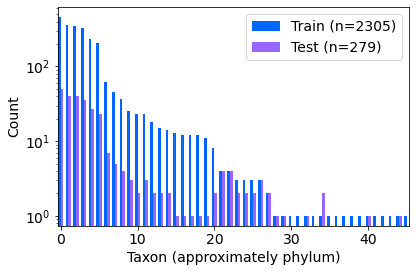

In [21]:
fig = data_viz.plot_tax_dist(c_train_genomes, c_test_genomes, train_tax_dict, test_tax_dict)
plt.savefig(BASE_DIR+"tax_dist.pdf", bbox_inches='tight')

Plot the distribution of genes per genome vector. The number of genes annotated by KEGG per genome in the training and test sets are shown. Genomes with fewer than 500 gene annotations have been excluded from the dataset.

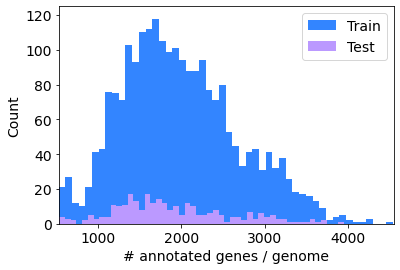

In [22]:
fig = data_viz.genes_per_genome(c_train_genomes, c_test_genomes, tnum_to_kos, tla_to_tnum)
plt.savefig(BASE_DIR+"genes_per_genome.pdf", figsize=(370.336, 245.416), bbox_inches='tight')

Plot histogram showing the number of modules per training genome

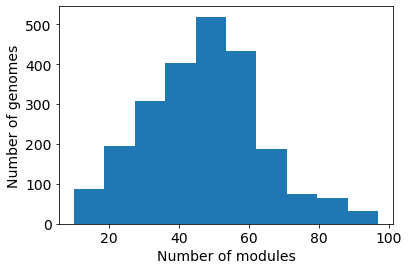

In [23]:
fig = data_viz.mods_per_train_genome(tla_to_mod_to_kos, c_train_genomes)

## Define and train a model

This notebook allows you to either train a single VAE model (no HPO) or load a model from file. To perform HPO use the standalone "hpo.py" script (recommended that you use an HPC cluster).

Note that the trainable.py script (both for training single VAEs here or using hpo.py) loads data from files saved to disk. This is because the files are huge and we want to do this only once. Therefore you must make sure you are using the desired files for training. To do this, edit the config file TRAIN_DATA_ROOT and TEST_DATA_ROOT parameters.

To train a model from scratch:

In [ ]:
train_from_scratch = False
date = pre_process.datenow()
save_as = BASE_DIR+"VAE_"+date
n_mods = '10' # max number of modules used for corruption -- used to save label saved model, etc.

if train_from_scratch:
    # Set hyperparameters
    nn_layers = 3
    weight_decay = 0.1
    lr = 0.001
    batch_size = 128
    kfolds = 10
    num_epochs = 3
    replacement_threshold = 0.5
    
    # Train model
    kld, bce, train_losses, test_losses,\
    train_f1s, test_f1s, model = trainable.train_single_vae(nn_layers, weight_decay, lr, \
                                                            batch_size, kfolds, num_epochs,\
                                                            replacement_threshold, BASE_DIR)
    
    # Save model and associated data
    print("Saving model with basename",save_as+"_"+n_mods+"mods")
    trainable.save_model(save_as+"_"+n_mods+"mods", kld, bce, train_losses, test_losses,\
                         train_f1s, test_f1s, model)

To load a model:

In [26]:
load_model = True
#name = "final_10mod"
name = BASE_DIR+"VAE_2021-12-19-22-16-27_10mods"

if load_model:
    model, train_losses, test_losses,\
    train_f1s, test_f1s, bce, kld = trainable.load_model(name)

# Evaluate model performance

### Generate or load predictions on test set

In [260]:
# Remember model was trained using file specified in config / data
num_features = data.num_features
corrupted_test = data.test_data[:,:num_features]
uncorrupted_test = data.test_data[:,num_features:] 
tnum_to_tax = pre_process.make_tnum_to_tax(train_tax_dict, test_tax_dict, tla_to_tnum)

Make or load new predictions. Note that pred is predictions as probability values, whereas binary_pred is binary predictions.

In [47]:
new_preds = False # make new predictions (True) or load ones from file (False)

binarizer_threshold = 0.5
name = BASE_DIR+"VAE_2021-12-19-21-35-44_10mods" # name of file to save or load

pred, binary_pred = evaluate.make_pred(new_preds, model, corrupted_test, binarizer_threshold, name)

### Calculate test set F1 score (micro-average) and calculate TNs, FPs, FNs, TPs

In [48]:
f1 = sk.metrics.f1_score(uncorrupted_test, binary_pred, zero_division=0, average='micro')
print("Test set F1 score:",f1)

Test set F1 score: 0.8102901401469595


median F1 score: 0.8156524397538314 min 0.3783969728242174 max 0.9836381135707412


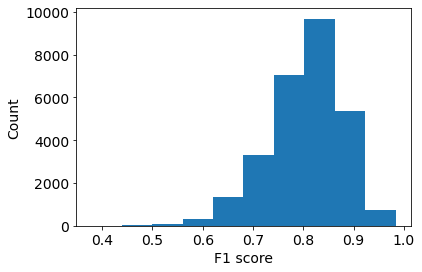

In [49]:
f1s, fig = evaluate.test_f1s(uncorrupted_test, binary_pred)
#plt.savefig(BASE_DIR+"f1_dist.pdf", bbox_inches='tight')

In [62]:
tns, fps, fns, tps = evaluate.confusion(uncorrupted_test, binary_pred)

The percentage of TNs, FPs, FNs, and TPs, respectively, is: 83.05 2.21 3.2 11.55


### Compare BCE and KLD loss via optimization learning curve

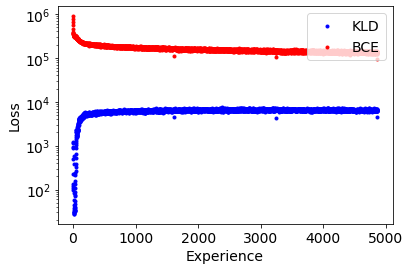

In [63]:
fig = evaluate.kld_vs_bce(kld, bce)

### Plot learning & ROC curves

Make a figure for the manuscript that includes optimization & performance LCs and the ROC curve

max F1 score 0.8476908699279638


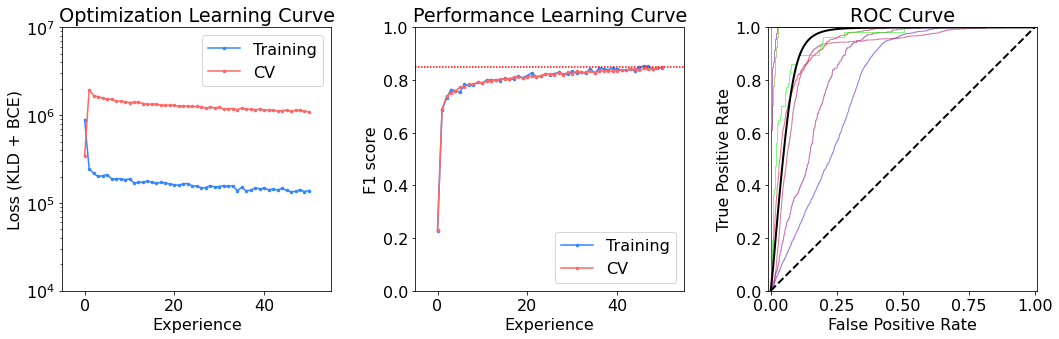

In [77]:
fig = evaluate.learningNroc_curve(train_losses, test_losses, train_f1s, test_f1s, corrupted_test.numpy(), pred.numpy())
#fig.savefig(BASE_DIR+"LCroc_fig.pdf", dpi=200, bbox_inches='tight')

### Are the input genes present in the output?

There are 4793 instance of inputs being 100% present in output
This is out of 27900 instances or 17.18% of cases
There are 22303 instance of inputs being >=90% present in output (79.94%)


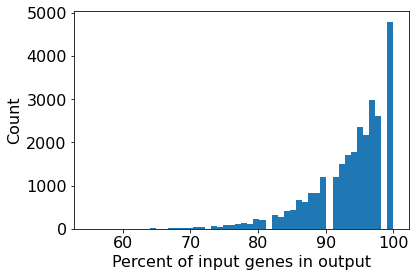

In [78]:
fig = evaluate.compare_in_n_out(binary_pred, corrupted_test)
#fig.savefig(BASE_DIR+"input_vs_output.pdf", bbox_inches='tight', dpi=200)

### What are the best, median, and worst reconstruction results from the test set?

In [80]:
best, median, worst = evaluate.best_med_worst(f1s, c_test_genomes, tla_to_tnum)

In [82]:
print(best)
print(median)
print(worst)

[3933, 'bbg', 0.9836381135707412, 'T02109']
[9650, 'flu', 0.8156521739130435, 'T05019']
[21714, 'seny', 0.3783969728242174, 'T05311']


### Plot pixel diagrams for best, median, and worst reconstructions

These figures offer a visual representation of how many TNs, FPs, FNs, and TPs there were for any given genome vector reconstruction. 

Panels compare the original, uncorrupted genome vector, the corrupted genome vector, and the generated (or reconstruced) genome vector that the model produce from the corrupted input. 

Each pixel represents a gene in the full dataset of genes. For the "original" and "corrupted" panels, green pixels represent genes that are encoded by the genome vector, while black pixels represent genes that are not encoded. 

In the "Generated" panel, green pixels represent true positives, black pixels represent true negatives, yellow represents false positives, and magenta represents false negatives.

White pixels in the bottom right are padding since the number of features does not have a perfect square.

Corrupted -- Genes on: 203 Genes off: 9660
Uncorrupted -- Genes on: 662 Genes off: 9201
Generated -- TN: 9335 FP: 14 FN: 3 TP: 511
The F1 score for this reconstruction was 0.9836381135707412


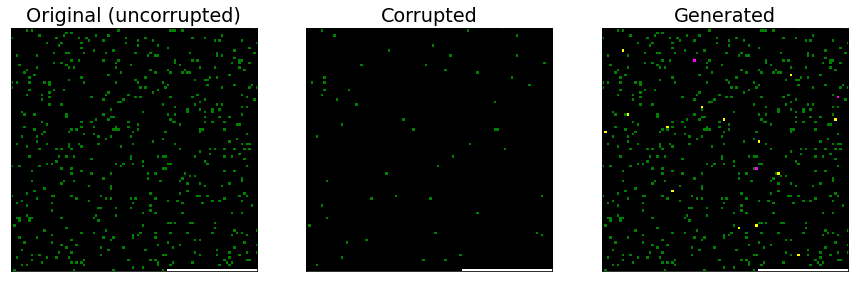

In [113]:
# Best reconstruction
idx = best[0]
fig = evaluate.pixel_diagram(corrupted_test, uncorrupted_test, idx, model, f1s, tns, fps, fns, tps, binary_pred)
#fig.savefig(BASE_DIR+"fig4_best.pdf", bbox_inches='tight', dpi=200)

Corrupted -- Genes on: 202 Genes off: 9661
Uncorrupted -- Genes on: 1339 Genes off: 8524
Generated -- TN: 8501 FP: 171 FN: 253 TP: 938
The F1 score for this reconstruction was 0.8156521739130435


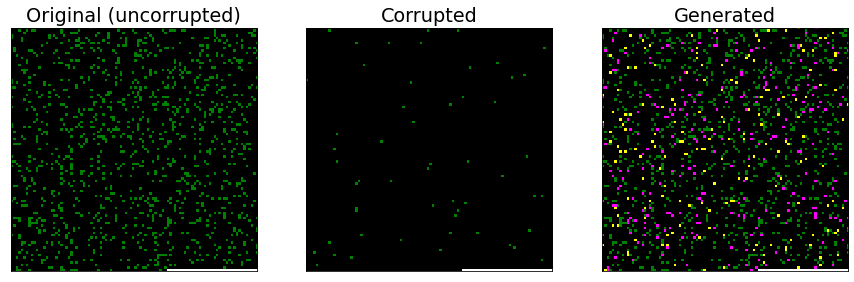

In [124]:
# Median reconstruction
idx = median[0]
fig = evaluate.pixel_diagram(corrupted_test, uncorrupted_test, idx, model, f1s, tns, fps, fns, tps, binary_pred)
#fig.savefig(BASE_DIR+"fig4_median.pdf", bbox_inches='tight', dpi=200)

Corrupted -- Genes on: 192 Genes off: 9671
Uncorrupted -- Genes on: 698 Genes off: 9165
Generated -- TN: 7506 FP: 1807 FN: 0 TP: 550
The F1 score for this reconstruction was 0.3783969728242174


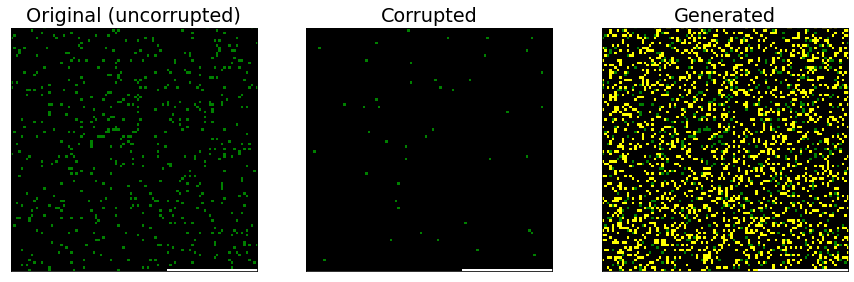

In [125]:
# Worst reconstruction
idx = worst[0]
fig = evaluate.pixel_diagram(corrupted_test, uncorrupted_test, idx, model, f1s, tns, fps, fns, tps, binary_pred)
#fig.savefig(BASE_DIR+"fig4_worst.pdf", bbox_inches='tight', dpi=200)

### Plot TN, TP, FN, FP barplots for best, median, and worst reconstructions

As an alternative method for visualizing TN, TP, FN, FP for reconstructions, plot barplots. 

labels ['TN', 'TP', 'FN', 'FP']
bbg F1: 0.9836381135707412
generated genome: [511, 9335, 3, 14]
generated genome: [5.18, 94.65, 0.03, 0.14]



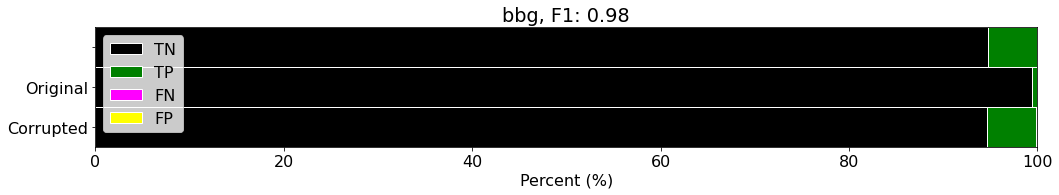

In [119]:
# Best reconstruction
idx = best[0]
fig = evaluate.snowplot(f1s, c_test_genomes, tns, fps, fns, tps, uncorrupted_test, corrupted_test, idx)
#fig.savefig(BASE_DIR+"barh_best.pdf", bbox_inches='tight', dpi=200)

labels ['TN', 'TP', 'FN', 'FP']
flu F1: 0.8156521739130435
generated genome: [938, 8501, 253, 171]
generated genome: [9.51, 86.19, 2.57, 1.73]



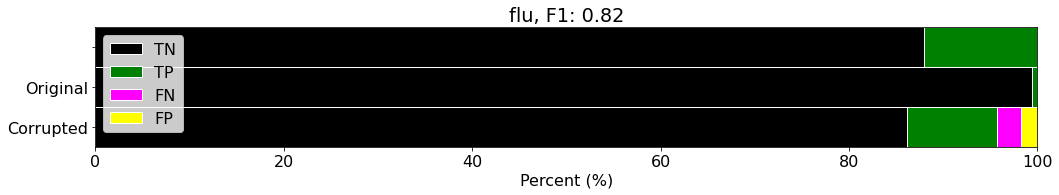

In [126]:
# Median reconstruction
idx = median[0]
fig = evaluate.snowplot(f1s, c_test_genomes, tns, fps, fns, tps, uncorrupted_test, corrupted_test, idx)
#fig.savefig(BASE_DIR+"barh_median.pdf", bbox_inches='tight', dpi=200)

labels ['TN', 'TP', 'FN', 'FP']
seny F1: 0.3783969728242174
generated genome: [550, 7506, 0, 1807]
generated genome: [5.58, 76.1, 0.0, 18.32]



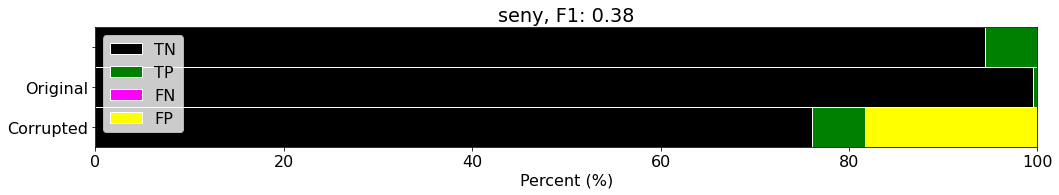

In [127]:
# Worst reconstruction
idx = worst[0]
fig = evaluate.snowplot(f1s, c_test_genomes, tns, fps, fns, tps, uncorrupted_test, corrupted_test, idx)
#fig.savefig(BASE_DIR+"barh_worst.pdf", bbox_inches='tight', dpi=200)

### For best, median, and worst reconstructions, what are the most similar "original genomes" to the reconstruction

The VAE scores each reconstruction based on how similar it is to the original, uncorrupted genome from which the corrupted VAE input was derived. 

But what if the VAE generates a "realistic" genome that simply doesn't look like the original -- rather looks like a different genome from the dataset? 

How closely do reconstructions resemble original, uncorrupted genomes?

Why do some reconstructions have high F1 scores while others don't?

Start with the best reconstruction from the test set

Get the 10 closest uncorrupted genome vectors from the training set (distance measured with the Hamming distance)

In [328]:
ten_df, closest_genomes = evaluate.get_ten_closest(best[0], best[3], test_genomes, 
                                                   train_genomes, test_data, train_data,
                                                   binary_pred, train_tax_dict, test_tax_dict, tnum_to_tla)

For the Generated genome vector and top two closest uncorrupted training genome vectors, plot venn diagram showing overlap in the identity of shared genes.

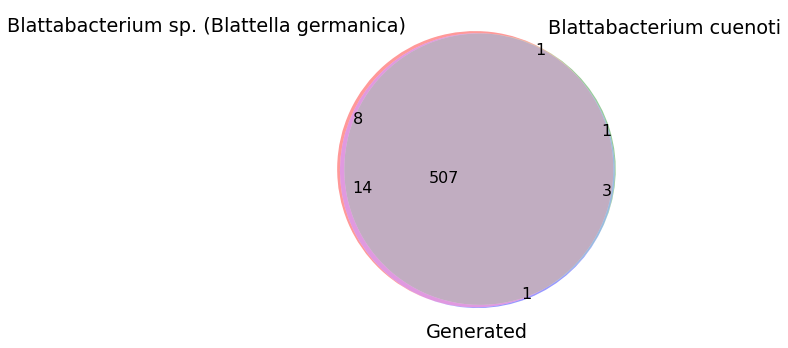

In [332]:
name1 = tnum_to_tax[closest_genomes[0]][6]
name2 = tnum_to_tax[closest_genomes[1]][6]

fig, ax = evaluate.compare_venn(name1, name2, 'Generated', ten_df)
#ax.figure.savefig(BASE_DIR+"best_venn.pdf", bbox_inches='tight', dpi=200)

Given the n input modules to the VAE model, how many training set genome vectors share those modules? How many possible genome vectors could it have been "inspired" by?

There are 95 genomes in the training set that have all ten mods present in the corrupted input


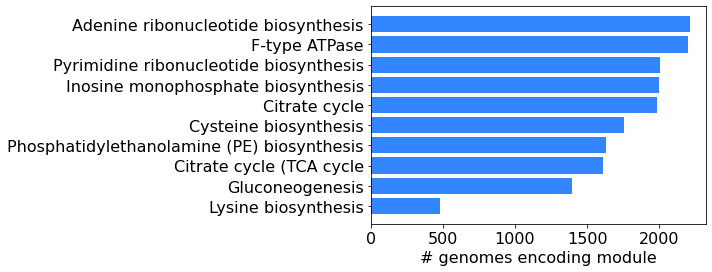

In [333]:
mod_names = evaluate.map_proc_mod()
fig, all_ten = evaluate.compare_inputs(test_input_mods, index_now, tla_to_mod_to_kos, 
                                       train_genomes, tla_to_tnum, mod_names)
print("There are",len(all_ten),"genomes in the training set that have all ten mods present in the corrupted input")

Is there a correlation between the number of genome vectors encoding the n mods used as input and the F1 score out generated genome vectors? For example, if all 10 input modules to the VAE happen to be very common, does the VAE have more license in what it creates, therefore potentially decreasing the F1 score because the reconstruction may more resemble species X instead of the original input species.

Repeat for the median reconstruction

In [ ]:
ten_df, closest_genomes = evaluate.get_ten_closest(median[0], median[3], test_genomes, 
                                                   train_genomes, test_data, train_data,
                                                   binary_pred, train_tax_dict, test_tax_dict, tnum_to_tla)

In [ ]:
name1 = tnum_to_tax[closest_genomes[0]][6]
name2 = tnum_to_tax[closest_genomes[1]][6]

fig, ax = evaluate.compare_venn(name1, name2, 'Generated', ten_df)
#ax.figure.savefig(BASE_DIR+"median_venn.pdf", bbox_inches='tight', dpi=200)

In [ ]:
mod_names = evaluate.map_proc_mod()
fig, all_ten = evaluate.compare_inputs(test_input_mods, index_now, tla_to_mod_to_kos, 
                                       train_genomes, tla_to_tnum, mod_names)
print("There are",len(all_ten),"genomes in the training set that have all ten mods present in the corrupted input")

Repeat for the worst reconstruction

In [ ]:
ten_df, closest_genomes = evaluate.get_ten_closest(worst[0], worst[3], test_genomes, 
                                                   train_genomes, test_data, train_data,
                                                   binary_pred, train_tax_dict, test_tax_dict, tnum_to_tla)

In [ ]:
name1 = tnum_to_tax[closest_genomes[0]][6]
name2 = tnum_to_tax[closest_genomes[1]][6]

fig, ax = evaluate.compare_venn(name1, name2, 'Generated', ten_df)
#ax.figure.savefig(BASE_DIR+"worst_venn.pdf", bbox_inches='tight', dpi=200)

In [ ]:
mod_names = evaluate.map_proc_mod()
fig, all_ten = evaluate.compare_inputs(test_input_mods, index_now, tla_to_mod_to_kos, 
                                       train_genomes, tla_to_tnum, mod_names)
print("There are",len(all_ten),"genomes in the training set that have all ten mods present in the corrupted input")

### Is there a correlation between F1 score and the "commonness" of the modules input to the VAE

How we will measure "commonnoess": the number of training set genomes that encode that modules

In [ ]:
fig, num_shared_mods = evaluate.nmods_vs_f1(c_test_genomes, test_input_mods, tla_to_mod_to_kos, tla_to_tnum, train_genomes, f1s)
#plt.savefig(BASE_DIR+'numMods_vs_F1.pdf', dpi=200)

### Is there are relationship between test F1 score and genetic relatedness (genus level) to training set genomes?

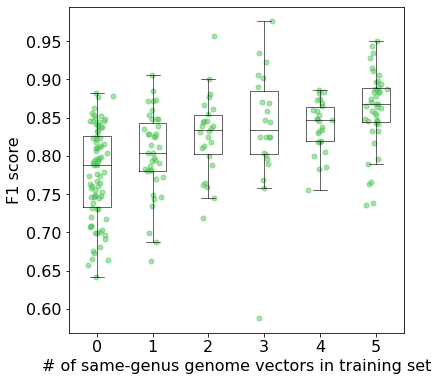

In [345]:
fig, groups = evaluate.genus_boxplot(c_test_genomes, tla_to_tnum, train_genomes,
                                     tnum_to_tax, tax_groups, f1s)
#fig.savefig(BASE_DIR+"genus_boxplot.pdf", bbox_inches='tight', dpi=200)

Is there a statistically significant difference?

In [346]:
anova, tukey = evaluate.genus_boxplot_stats(groups)

/usr/local/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.11, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [347]:
anova

,Source,ddof1,ddof2,F,p-unc,np2
0,group,5,232,15.442298,4.166221e-13,0.249704


In [348]:
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0    0.027   0.14 -0.0045 0.0584  False
   0.0    2.0   0.0504 0.0013   0.014 0.0868   True
   0.0    3.0   0.0602  0.001  0.0213  0.099   True
   0.0    4.0   0.0619  0.001  0.0255 0.0983   True
   0.0    5.0   0.0843  0.001  0.0538 0.1147   True
   1.0    2.0   0.0234   0.56 -0.0175 0.0644  False
   1.0    3.0   0.0332 0.2353 -0.0099 0.0764  False
   1.0    4.0   0.0349 0.1437  -0.006 0.0759  False
   1.0    5.0   0.0573  0.001  0.0215 0.0931   True
   2.0    3.0   0.0098    0.9 -0.0371 0.0567  False
   2.0    4.0   0.0115    0.9 -0.0334 0.0563  False
   2.0    5.0   0.0339 0.1534 -0.0063 0.0741  False
   3.0    4.0   0.0017    0.9 -0.0452 0.0486  False
   3.0    5.0   0.0241 0.5681 -0.0183 0.0665  False
   4.0    5.0   0.0224 0.5854 -0.0178 0.0626  False
---------------------------------------------------


### How does the model perform on inputs originating from different phyla

Count the number of phylum members for all phyla in the training and test sets

In [367]:
train_phyla, test_phyla = evaluate.f1s_per_phylum(train_tax_dict, test_tax_dict, c_test_genomes, f1s)
print("FYI there are a total of", len(set(list(train_phyla.keys()) 
      + list(test_phyla.keys()))), "phyla in the full dataset") 

FYI there are a total of 46 phyla in the full dataset


Best: Chlorobi 0.9060052219321149
Worst: Acidobacteria 0.6661108795331387


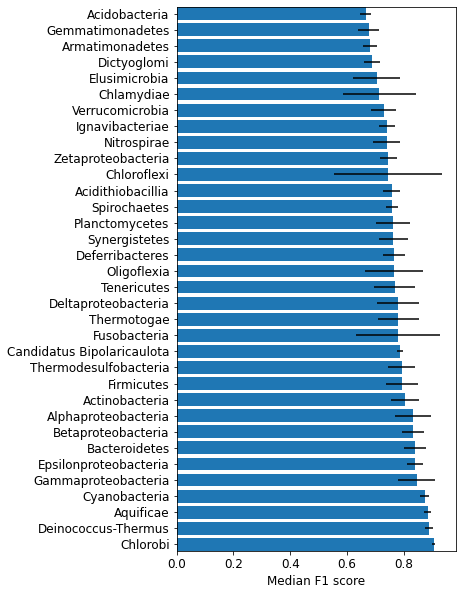

In [359]:
# Bars represent median absolute deviation
fig = evaluate.plot_f1_per_phylum(test_phyla, (5,10))
#fig.savefig(BASE_DIR+"f1_per_phylum.png", dpi=200, bbox_inches='tight')

In [360]:
# Are the results between phyla statistically significant?
stats.kruskal(*test_phyla.values())

KruskalResult(statistic=6563.832381548758, pvalue=0.0)

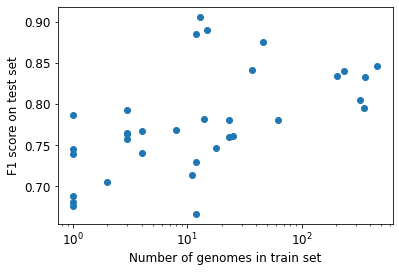

In [361]:
fig = evaluate.plot_count_vs_f1s(train_phyla, test_phyla)

There appears to be an effect of number of training genomes / phylum on test set per phylum F1 score 

### How many times is each mod used in the various corrupted inputs?
Calculate the number of times each mod occurs in the training set corrupted genomes and plot.

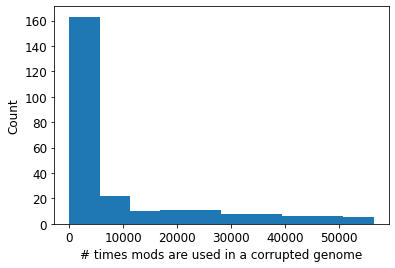

In [374]:
fig = evaluate.plot_train_count_hist(train_input_mods)

### How does genome size correlate with F1 score

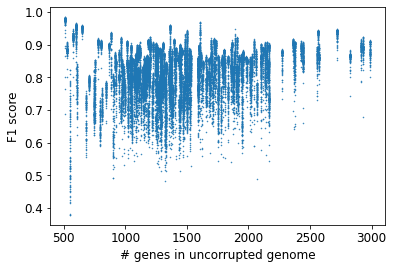

In [383]:
fig = evaluate.ngenesUncorrupted_vs_f1(uncorrupted_test, f1s)

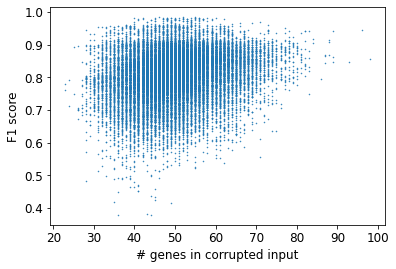

In [385]:
fig = evaluate.ngenesCorrupted_vs_f1(corrupted_test, f1s)

### Analyze F1 scores of actual KOs

To start, lets make a histogram for F1 score per gene 

There are 2444 KOs with F1=0 out of 9863 KOs. That is 24.779478860387304 %
There are 77 genes that are always off in the training set


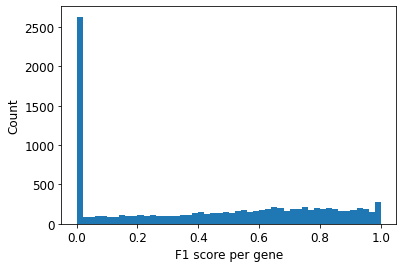

In [402]:
fig, ko_f1s = evaluate.f1_per_ko(uncorrupted_test, binary_pred, train_data)

Now plot gene count in the uncorrupted training set vs per gene test F1 score

max KO count: 230300
total number of training genomes: 230500


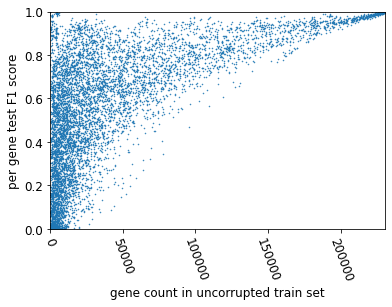

In [405]:
fig = evaluate.geneCount_vs_geneF1(corrupted_train, num_features, ko_f1s)

### Generate multi-panel figure for paper

max KO count: 230300
total number of training genomes: 230500


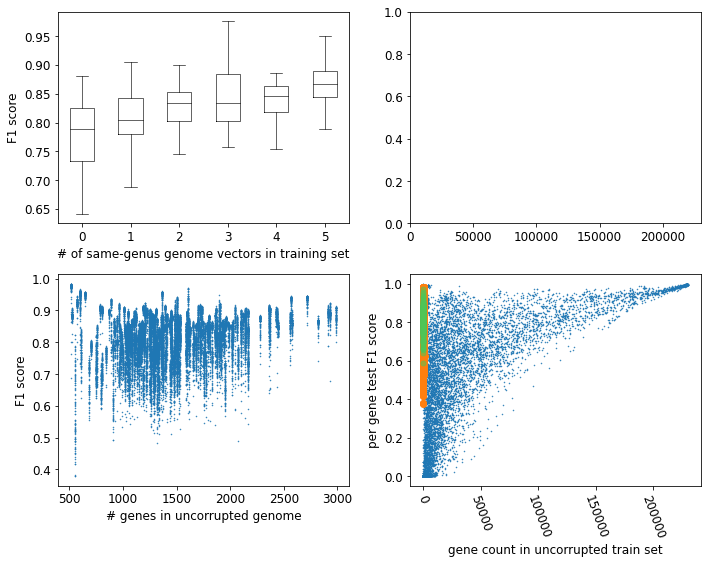

In [416]:
fig = evaluate.model_performance_factors(c_test_genomes, tla_to_tnum, tnum_to_tax, tax_groups, f1s,
                                         corrupted_train, num_features, ko_f1s, uncorrupted_test, 
                                         train_genomes, test_input_mods, tla_to_mod_to_kos)

In [ ]:
#fig.savefig(BASE_DIR+"bio_insights_contd.pdf", dpi=200, bbox_inches='tight')
#fig.savefig(BASE_DIR+"bio_insights_contd.png", dpi=400, bbox_inches='tight')

### F1 score on KOs + what metab pathway they are part of

Figure out which mods belong to which processes (e.g.: nucleotide metabolism) and subprocesses (e.g.: purine synthesis)

In [ ]:
process_to_mod, mod_to_proc = evaluate.map_proc_mod1()
subprocess_to_mod, mod_to_subproc = evaluate.map_subproc_mod()

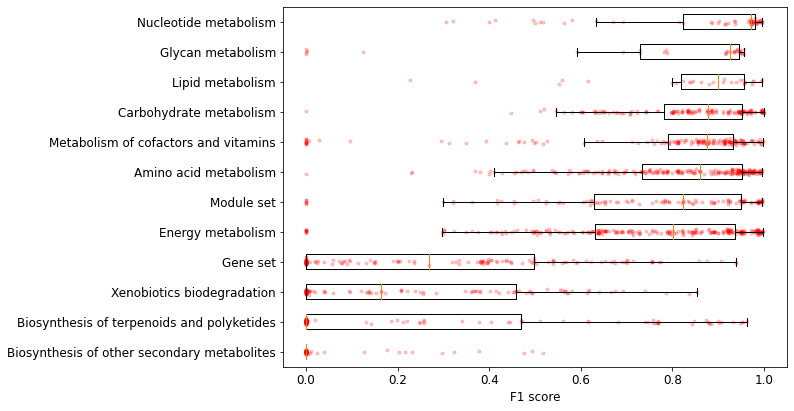

In [420]:
fig = evaluate.plot_metab_pathway_f1_horizontal(process_to_mod, mod_to_ko_clean, all_kos, ko_f1s, (7,5))

Is there a statistical difference between the F1 scores of genes from different processes?

In [421]:
stats.kruskal(*proc_to_ko_F1s.values())

KruskalResult(statistic=849.4725656704286, pvalue=4.830950177848231e-155)

In [ ]:
### How does the model do on different types of genes (kinases vs transferases, etc) 

### Generate a multi-panel figure for the paper

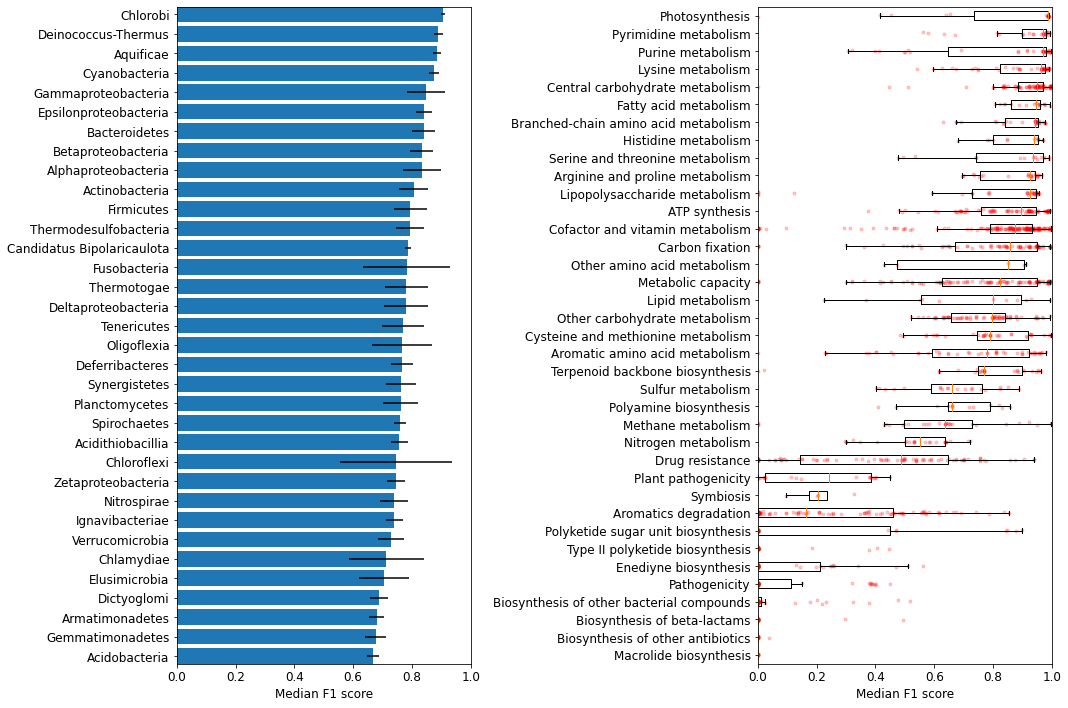

In [423]:
fig = evaluate.bio_insights_fig(test_phyla, subprocess_to_mod, all_kos, ko_f1s, mod_to_ko_clean)
#fig.savefig(BASE_DIR+"bio_insights_fig.pdf", dpi=200, bbox_inches='tight')

### How does the count of each mod in training set (pre-corruption) correlate with median F1 score

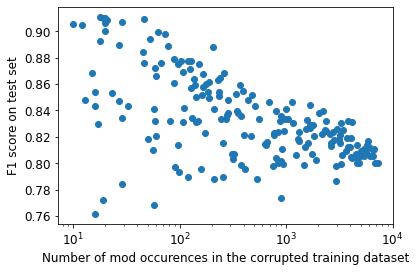

In [424]:
fig = evaluate.plot_mod_count_vs_f1_v2(test_input_mods, f1s, train_out)

# Qualitatively evaluate generated genome vectors

Now we have some idea about how well the model qualitatively performs. This is a fairly limited way of analyzing how "realistic" generated genome vectors are, though. For example, if we selected a set of 10 input modules for the VAE which are very common across bacteria, the VAE loss will be based on how will it reconstructed the original genome. But maybe there are 100 other genomes that encode the exact same 10 modules -- and therefore many different viable genomes that could encode that set.

So now let's look at some qualitative metrics for evaluating the realism of generated genome vectors.

First we will use the trained model to generate some new genome vectors

In [430]:
# Generate 100 genomes using random sets of 10 modules
new_genomes = False
n_gen = 100 # number of genomes to generate
n_mods = 10 # number of mods to use as input

if new_genomes:
    date = pre_process.datenow()
    print('files will be saved as',BASE_DIR+"generated_genomes_"+date+".pt","and", "generated_genome_inputs_"+date+".pt")
    generated, generated_inputs = evaluate.generate_genomes(n_gen, all_kos, mod_to_ko_clean, n_mods, model)
    torch.save(generated, BASE_DIR+"generated_genomes_"+date+".pt")
    torch.save(generated_inputs, BASE_DIR+"generated_genome_inputs_"+date+".pt")
else:
    #date_to_load = '2021-02-01'
    date_to_load = "2021-12-20-18-48-35"
    generated = torch.load(BASE_DIR+"generated_genomes_"+date_to_load+".pt")
    generated_inputs = torch.load(BASE_DIR+"generated_genome_inputs_"+date_to_load+".pt")

We will randomly select one of the generated genomes for in depth metabolic analysis later on

In [445]:
idx = random.randint(test_data.shape[0], test_data.shape[0]+n_gen) #idx = 292
gen_idx = idx - test_data.shape[0] # generated genomes follow test set genomes in tensor

### PCA ordination of Jaccard similarity between real & generated genome vectors

Motivation: if real and generated genomes occupy different parts of the PCA plot, it suggests there is a serious fundamental difference in their composition. Alternatively, if their distributions overlap, it suggests a qualitative similarity.

### Plot PCA of Jaccard similarity between genomes, using Hamming loss as a distance metric

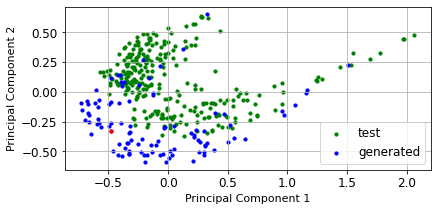

In [448]:
fig = evaluate.pca_gen_vs_real(generated, test_data, idx)
#fig.savefig(BASE_DIR+"pca_jaccard.pdf", dpi=200, bbox_inches='tight');

### Distributions of genes and modules per genome for real vs generated genomes

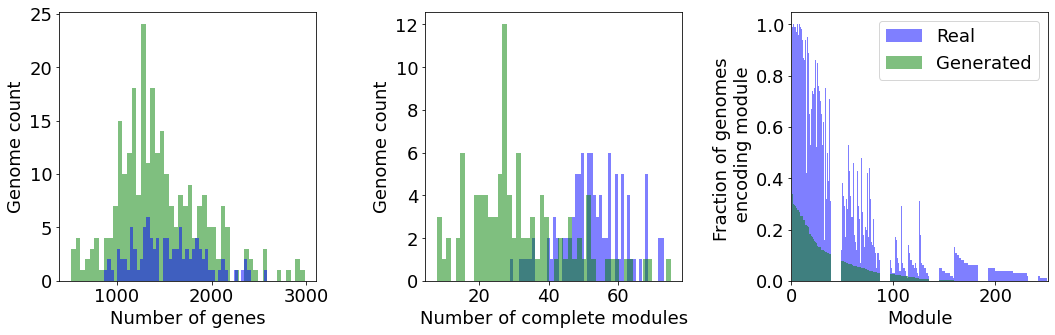

In [480]:
fig = evaluate.dist_genes_mods(generated, all_kos, mod_to_ko_clean, test_data)
#fig.savefig(BASE_DIR+"count_dists.pdf", dpi=200, bbox_inches='tight')

### Begin analysis of the randomly selected generated genome

Of genes selected for input to the VAE, how many are also present in the output?

There are 100 instance of inputs being 100% present in output
This is out of 100 instances or 100.0% of cases
There are 100 instance of inputs being >=90% present in output (100.0%)


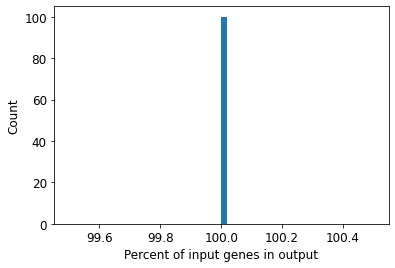

In [452]:
fig = evaluate.compare_in_n_out(generated, gen_corrupted)

Which modules were used as inputs to the generated genome vector?

In [487]:
generated_inputs[gen_idx][0]

Genome was generated using the following mods as input


['M00702',
 'M00167',
 'M00534',
 'M00613',
 'M00134',
 'M00527',
 'M00550',
 'M00638',
 'M00007',
 'M00612']

In the event that not all mods are complete, you can figure out which ones they are and how incomplete they are with the following code

In [500]:
# evaluate.id_incomplete_mods(generated_inputs, gen_idx, mod_to_ko_clean, gen_kos)

How many and which genes do/es this correspond to?

In [497]:
gen_kos = evaluate.kos_in_gen(generated, gen_idx, all_kos)

There are a total of 1309 genes encoded in this genome vector


Assess ribosomal completeness

In [492]:
pathways.confirm_ribosome(gen_kos)

missing RP S30
missing RP S31
missing RP L7A
ssu_count 21 / 23
lsu_count 33 / 34


Assess rRNA gene completeness (16S, 5s, 23s)

In [493]:
pathways.confirm_rrna(gen_kos)

present 3 / 3


The next steps of the metabolic analysis for our selected generated genome will be done using KAAS (https://www.genome.jp/tools/kaas/). Now we convert the generated genome vector into a format that will be accepted by KAAS.

More specifically, we will take the binary genome vector and format them as a faa file of gene that can be input to KAAS for analysis. The exact protein sequence for a given gene will be selected randomly -- improvements to this selection process are something to think about for future work.

In [ ]:
save_to = BASE_DIR+'prot_out_'+str(gen_idx)+'.txt'
ko_new = evaluate.new_genome_random(mod_to_ko_clean, model, all_kos, save_to, BASE_DIR)

### Parsimony-based dendrogram of real vs generated genomes

Motivation: above, we used hamming distance + Jaccard similarity to measure how similar real vs generated genome vectors are to one another. This considers gene overlap but not gene identity. For example, if all generated genomes were lacking ribosomes, rRNA genes, and other core machinery/pathways, they would be deeply abnormal, even if they were identical to the real genomes in all other ways. To gain insight into whether the composition of generated genome vectors is similar to that of real genome vectors, we will make a parsimony-based dendrogram generated from a character matrix where each gene’s presence/absence in a genome is a character.

The core of this analysis will be done through third party programs, but we will prepare the data for those programs here.

Will use phylip to infer a parsimony-based dendrogram (mix program)

Will use iTOL platform (https://itol.embl.de/) for visualization (display, add colour strips, taxon labels)

Prepare "phylip_in.txt" file for input to phylip.

In [501]:
# Get archaeal root for dendrogram
barc_vec = evaluate.arch_root(all_kos)
# Reformat tensor for input to phylip
df = evaluate.df_for_phylip(generated, test_data, test_genomes, all_kos)
df = df.append(pd.DataFrame({col: [val] for col, val in zip(df.columns, barc_vec)}, ['outgroup_T04065']))
phylum_dict = evaluate.write_out_for_phylip(BASE_DIR, df, tnum_to_tla, test_tax_dict) # phylip_in.txt

file will be saved as /Users/natasha/Desktop/vae/phylip_in2021-12-20-20-0-20.txt


Some tips for how to do the analysis in phylip:
    1. Navigate to "phylip-3.695-vol", double click "mix" program
    2. Enter file name with path to dir ---> delete space at the end of the file name

Phylip will produce a tree file that can be uploaded to iTOL. To add colour strips to the tree for real vs generated genomes, as seen in the figure in the paper, you will need the following files:

In [503]:
# For parsimony dendrogram: generate real genomes' phylum-level colour strip file for iTOL 
phyla_colours = evaluate.get_phyla_colours()
evaluate.colour_real_itol(BASE_DIR, phyla_colours, phylum_dict) # vae_dendro_colours_real.txt

file will be saved as /Users/natasha/Desktop/vae/vae_dendro_colours_real2021-12-20-20-1-19.txt


In [504]:
# For parsimony dendrogram: generate generated genomes' colour strip file for iTOL
evaluate.colour_generated_itol(BASE_DIR, phylum_dict) # vae_dendro_colours_generated.txt

file will be saved as /Users/natasha/Desktop/vae/vae_dendro_colours_generated2021-12-20-20-1-37.txt


# Baseline models

### Baseline 1
Generate genome vectors by completely randomly turn on n bits, where n = a randomly selected number of genes encoded by a real genome from the training set.

In [514]:
new = True

if new:
    date = pre_process.datenow()
    print("Generating new baseline 1")
    baseline1 = evaluate.baseline1(corrupted_train, tla_to_mod_to_kos, tnum_to_kos, tla_to_tnum, 
                                   c_train_genomes, corrupted_test)
    torch.save(baseline1, BASE_DIR+"baseline1"+date+".pt")
else:
    date_to_open = ""
    print("Loading previously made baseline 1")
    baseline1 = torch.load(BASE_DIR+"baseline1"+date_to_open+".pt")

Generating new baseline 1


In [516]:
f1 = sk.metrics.f1_score(uncorrupted_test, baseline1, zero_division=0, average='micro')
f1

0.1927599047237731

In [518]:
tns, fps, fns, tps = evaluate.confusion(uncorrupted_test, baseline1)

In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
fig = data_viz.my_roc_curve(uncorrupted_test.numpy(), baseline1.numpy())

### Baseline 2
Generate genome vectors by randomly turn on n bits with the highest probability of being on across the entire training set. n = n = a randomly selected number of genes encoded by a real genome from the training set

In [505]:
new = True

if new:
    date = pre_process.datenow()
    print("Generating new baseline 2")
    baseline2 = evaluate.baseline2(corrupted_test, data.y.shape, tla_to_mod_to_kos, tnum_to_kos, tla_to_tnum, 
                                   c_train_genomes, corrupted_test)
    torch.save(baseline2, BASE_DIR+"baseline2"+date+".pt")
else:
    date_to_open = ""
    print("Loading previously made baseline 2")
    baseline2 = torch.load(BASE_DIR+"baseline2"+date_to_open+".pt")

Generating new baseline 2


In [ ]:
f1 = sk.metrics.f1_score(uncorrupted_test, baseline2, zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps = evaluate.confusion(uncorrupted_test, baseline2)


In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted_test.numpy(), baseline2.numpy())

### Baseline 3
Generate genome vectors using an untrained version of the VAE model.

In [ ]:
new = True

if new:
    date = pre_process.datenow()
    print("Generating new baseline 3")
    n_features = int(corrupted_test.shape[1]/2)
    fake_model = models.VariationalAutoEncoder(n_features, 3)
    fake_model.eval()
    with torch.no_grad():
        pred = fake_model.forward(corrupted_test[:,:n_features])[0].detach()
    baseline3 = evaluate.eval_binarize(pred, 0.5)
    torch.save(baseline3, BASE_DIR+"baseline3"+date+".pt")
else:
    date_to_open = ""
    print("Loading previously made baseline 3")
    baseline3 = torch.load(BASE_DIR+"baseline3"+date_to_open+".pt")

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted_test.long(), baseline3.long(), zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps = evaluate.confusion(uncorrupted_test, baseline3)

In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted_test.numpy(), baseline3.numpy())

### Baseline 4
All generated genome vectors are just copies of the smallest genome vector in the training set (_Hoaglandella endobia_ -- hed)

In [ ]:
new = True

if new:
    date = pre_process.datenow()
    print("Generating new baseline 4")
    baseline4 = evaluate.baseline4(corrupted_train, corrupted_test, tla_to_tnum, tnum_to_kos, c_train_genomes)
    torch.save(baseline4, BASE_DIR+"baseline4"+date+".pt")
else:
    date_to_open = ""
    print("Loading previously made baseline 4")
    baseline4 = torch.load(BASE_DIR+"baseline4"+date_to_open+".pt")

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted_test, baseline4, zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps = evaluate.confusion(uncorrupted_test, baseline4)

In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
fig = data_viz.my_roc_curve(uncorrupted_test.numpy(), baseline4.numpy())

### Baseline 5
All generated genome vectors are just copies of the largest genome vector in the training set (_Paraburkholderia caribensis_ -- bcai)

In [ ]:
new = True

if new:
    date = pre_process.datenow()
    print("Generating new baseline 5")
    baseline5, largest_tla = evaluate.baseline5(corrupted_train, corrupted_test, tla_to_tnum, 
                                                tnum_to_kos, c_train_genomes)
    torch.save(baseline5, BASE_DIR+"baseline5"+date+".pt")
else:
    date_to_open = ""
    print("Loading previously made baseline 5")
    baseline5 = torch.load(BASE_DIR+"baseline5"+date_to_open+".pt")

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted_test, baseline5, zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps = evaluate.confusion(uncorrupted_test, baseline5)

In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted_test.numpy(), baseline5.numpy())